In [ ]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import random

import scipy
from scipy.fft import fft, ifft

np.set_printoptions(precision=18, suppress=False)

# Variables

In [ ]:

# posición Ti
x_i = 3
y_i = 0.5
z_i = 4.5

# posición Rj1
x_j = 3
y_j = 1
z_j = 1.8

# posición del Rj2
x_j2 = 3
y_j2 = 1.5
z_j2 = 1.8

# posición del Rj3
x_j3 = 4
y_j3 = 2
z_j3 = 1.8

# posición del Rj4
x_j4 = 2.2
y_j4 = 2.5
z_j4 = 1.8

# posición del Rj5
x_j5 = 1
y_j5 = 2.5
z_j5 = 1.6

# posición del área reflectiva (pared) usar para puntos específicos de elementos reflectantes

# first reflection_point
x_w1 = 2
y_w1 = 2
z_w1 = 3

# second reflection_point
x_w2 = 1.5
y_w2 = 2.3
z_w2 = 4.0

# third reflection_point
x_w = 5
y_w = 2.9
z_w = 3.5

# position of scattering particle
# x_s = 4
# y_s = 4.5
# z_s = 2.5

# parámetros de la simulación

Aw = 1                                        # área del elemento reflectante
pw = 0.6                                      # coeficiente de reflexión del área reflectiva
ang_rad = 60                                  # semi-ángulo de mitad de potencia del LED
m = int(-np.log(2) / np.log(abs(np.cos(ang_rad * np.pi / 180))));   # número Lambertiano
Ap = 0.0001                                   # área física del receptor (1 cm^2)
eta = 1.5                                     # índice de refracción del PD
fov = 70                                      # field of view

# parámetros de los ángulos de inclinación y rotación

beta_i = 45                                   # ángulo de inclinación del LED con respecto al eje z
alpha_i = 45                                  # ángulo de rotación del LED con respecto al eje x

beta_j = 45                                   # ángulo de inclinación del PD con respecto al eje z
alpha_j = 45                                  # ángulo de rotación del PD con respecto al eje x

# wall rotation angles para ángulo específico
alpha_w = 20
beta_w = 70

gv = [20, 60]                                 # distribución uniforme de probabilidad
fv = [0, 5]                                   # distribución uniforme de probabilidad
W = 6                                         # ancho del obstáculo
H = 5                                         # altura del obstáculo
X = 6                                         # Longitud de la mina
Y = 3                                         # altura de la mina
es = 5                                        # epsilon
t = 5 * 10**-9                                # valor del tiempo
gymma = 0.017                                 # coeficiente de reflexión
g = 0.72                                      # responsividad
f = 0.5                                       # índice de refracción
kr = [0.1, 0.01]                              # distribución uniforme de probabilidad
km = [0, 10]                                  # distribución uniforme de probabilidad
ks = np.add(kr, km)                           # distribución uniforme de probabilidad
N = 70                                        # Número de scatterers
# rn=sqrt((x_j-x_s)^2+(y_j-y_s)^2+(z_j-z_s)^2);
p = 0.1                                       # el parámetro se utiliza en el cálculo de Gn debajo de la ecuación 3.21

c = 3 * 10**8                                 # velocidad de la luz

Sampling_time = 0.25e-9                       # 0.25 nano segundos de muestreo, se disminuye para mayor número de muestras
time = np.arange(0, 35e-9, Sampling_time)    # vector de tiempo donde se observará el CIR
time = np.round(time,9)                     # redondeo del tiempo
t_rise = 0.5e-9                               # subida del tiempo de subida del PD
t_fall = 1e-9                                 # tiempo de caída del PD
h_led = 10 * (np.exp(-time / t_fall) - np.exp(-time / t_rise))  # respuesta al impulso del PD


In [ ]:
np.size(time)

140

# FUNCIONES

In [ ]:
# this module will be imported in the into your flowgraph



# ///////////////FUNCIONES AUXILIARES PARA CALCULOS//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# function to calculate the d(xv,yv)
def dv(x1, y1, x2, y2, fv):


	return np.abs((y1 - y2) * fv[0] - (x1 - x2) * fv[1] - x2 * y1 + x1 * y2) / np.sqrt((y1 - y2) ** 2 + (x1 - x2) ** 2)


# function to calculate the s(xv,yv)
def sv(x1, y1, z1, x2, y2, z2, fv):
  if z1 <= z2:
    s_v = ((y1-y2)**2+(x1-x2)**2+(fv[0]-x1)**2+(fv[1]-y1)**2-((fv[0]-x2)**2+(fv[1]-y2)**2)/2*np.sqrt((y1-y2)**2+(x1-x2)**2))+z1;
  else:
    s_v = ((y1-y2)**2+(x2-x1)**2+(fv[0]-x2)**2+(fv[1]-y2)**2-((fv[0]-x1)**2+(fv[1]-y1)**2)/2*np.sqrt((y1-y2)**2+(x2-x1)**2))+z2;

  return s_v



# %funcion para calcular vector y distancia entre dos puntos
def point_to_vector(x1, y1, z1, x2, y2, z2):
    Vec = np.array([x2 - x1, y2 - y1, z2 - z1])
    length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2 + (z2 - z1) ** 2)

    return Vec, length


# Calculo del vector normal para transmisores
def norm_vec_trans(alpha, beta):
    n = np.array([np.cos(np.deg2rad(alpha)) * np.sin(np.deg2rad(beta)),
                  np.sin(np.deg2rad(alpha)) * np.sin(np.deg2rad(beta)),
                  -np.cos(np.deg2rad(beta))])
    return n

# funcion para calcular el producto punto
def dot_product(a, b):
    f = np.dot(a, b)
    return f

# Calculo del vector normal para receptores
def norm_vec_receiver(alpha, beta):
    m = np.array([np.cos(np.deg2rad(alpha)) * np.sin(np.deg2rad(beta)),
                  np.sin(np.deg2rad(alpha)) * np.sin(np.deg2rad(beta)),
                  np.cos(np.deg2rad(beta))])
    return m

# funcion para calcular la ganancia
def gain(eta, incide, incide_r, fov):
    if (incide_r <= 2 * fov) and (incide_r >= 0):
        g = (eta ** 2) / (np.sin(incide) ** 2)
    else:
        g = 0
    return g



# ////////////// FUNCIONES PROBABILISTICAS /////////////////

# Function to calculate the  Pij for shadowing model
def P_expt(gv, fv, W, H, X, Y, t, es, d_v, s_v):
    w, h, x, y, p, E = sp.symbols('w h x y p E')

    if (gv[0] >= 2 * d_v) and (gv[1] >= s_v):
        w_int = sp.integrate(gv[0], (w, 0, W))
        h_int = sp.integrate(gv[1], (h, 0, H))
        A = [w_int, h_int]
        x_int = sp.integrate(fv[0], (x, 0, X))
        y_int = sp.integrate(fv[1], (y, 0, Y))
        B = [x_int, y_int]
        exp_value = sum(a * b for a, b in zip(A, B))
        f = p * t
        est = -es * exp_value
        d = sp.N(f.subs(p, est), 8)
        f = sp.exp(E)
        Pij = sp.N(f.subs(E, d), 4)
    else:
        Pij = 0

    return Pij


def pmie(f, g, phi_i_sn):
    p_mie = ((1 - g**2 / (4 * np.pi)) * (1 / ((1 + g**2 - 2 * g * np.cos(np.radians(phi_i_sn)))**1.5)
              + f * 3 * (np.cos(np.radians(phi_i_sn)))**2 - 1 / 2 * (1 + g**2)**1.5))
    return p_mie

def pray(gymma, phi_i_sn):
    p_ray = 3 * (1 + 3 * gymma + (1 - gymma) * (np.cos(np.radians(phi_i_sn)))**2) / (16 * np.pi * (1 + 2 * gymma))
    return p_ray


# Obtencion parametro Phi para Scattering
def phi_scater(x1, y1, z1, x2, y2, z2, alpha, beta):
    v = np.array([x1 - x2, y1 - y2, z1 - z2])
    Ntilt = np.array([np.cos(np.radians(alpha)) * np.sin(np.radians(beta)),
                      np.sin(np.radians(alpha)) * np.sin(np.radians(beta)),
                      -np.cos(np.radians(beta))])
    d_p = np.dot(v, Ntilt)
    d = np.linalg.norm(v)
    phi_i_sn = np.arccos(d_p / d)
    return phi_i_sn

def Bisn(theta_sn_j, theta_ij):
    if theta_ij < theta_sn_j:
        B_i_sn = theta_sn_j - theta_ij
    else:
        B_i_sn = theta_ij - theta_sn_j
    return B_i_sn



# ///////////////// FUNCIONES CALCULOS FISICOS ///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# funcion para calcular grado de inclinacion/incidencia
def incline(x_i, y_i, z_i, x_j, y_j, z_j, alpha_j, beta_j):
    # Vector from transmitter to receiver
    dx = x_j - x_i
    dy = y_j - y_i
    dz = z_j - z_i

    # Normal vector of the receiver
    nx = np.sin(np.radians(beta_j)) * np.cos(np.radians(alpha_j))
    ny = np.sin(np.radians(beta_j)) * np.sin(np.radians(alpha_j))
    nz = np.cos(np.radians(beta_j))

    # Unit vector from transmitter to receiver
    mag = np.sqrt(dx**2 + dy**2 + dz**2)
    ux = dx / mag
    uy = dy / mag
    uz = dz / mag

    # Angle of incidence (in radians)
    incidencia_radian = np.arccos(nx * ux + ny * uy + nz * uz)

    return np.degrees(incidencia_radian)


# funcion para calcular el angulo de irradiancia%
def rotacion(x_j, y_j, z_j, x_i, y_i, z_i, alpha_i, beta_i):
    # Vector from receiver to transmitter
    dx = x_i - x_j
    dy = y_i - y_j
    dz = z_i - z_j

    # Normal vector of the transmitter
    nx = np.sin(np.radians(beta_i)) * np.cos(np.radians(alpha_i))
    ny = np.sin(np.radians(beta_i)) * np.sin(np.radians(alpha_i))
    nz = np.cos(np.radians(beta_i))

    # Unit vector from receiver to transmitter
    mag = np.sqrt(dx**2 + dy**2 + dz**2)
    ux = dx / mag
    uy = dy / mag
    uz = dz / mag

    # Angle of irradiance (in radians)
    irradiancia_radian = np.arccos(nx * ux + ny * uy + nz * uz)

    return np.degrees(irradiancia_radian)

# Calculo de distancias
def DIST(x1, y1, z1, x2, y2, z2):
    D = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    return D




# funcion para calcular el HLoS


def HLoS_direct(x_i, y_i, z_i, x_j, y_j, z_j, Ap, eta, alpha_i, alpha_j, beta_i, beta_j, incidencia, incidencia_r, m, fov, gv, fv, W, H, X, Y, t, es, c):
    dv_ij = dv(x_i, y_i, x_j, y_j, fv)
    sv_ij = sv(x_i, y_i, z_i, x_j, y_j, z_j, fv)
    Pij = P_expt(gv, fv, W, H, X, Y, t, es, dv_ij, sv_ij)
    v1, d1 = point_to_vector(x_i, y_i, z_i, x_j, y_j, z_j)
    Nnorm1 = norm_vec_trans(alpha_i, beta_i)
    p1 = np.dot(v1, Nnorm1)
    v2, d2 = point_to_vector(x_j, y_j, z_j, x_i, y_i, z_i)
    Nnorm2 = norm_vec_receiver(alpha_j, beta_j)
    p2 = np.dot(v2, Nnorm2)
    g = gain(eta, incidencia, incidencia_r, fov)
    dm = d1 / c
    #dm = vpa(dm)
    dm = float(dm)#(subs(dm))

    if 0 <= incidencia <= 2 * fov:
        m_HLoS = abs(((m + 1) * Ap / (2 * np.pi * d1**2)) * (p1**m / d1) * (p2 / d2) * g * Pij)
        #m_HLoS = vpa(m_HLoS)
        m_HLoS = float(m_HLoS)#subs(m_HLoS))
    else:
        m_HLoS = 0

    return m_HLoS, dm



# funciones para calcular HNLos

def HnLos_calculation(x_i, y_i, z_i, x_j, y_j, z_j, x_w, y_w, z_w, Aw, pw, alpha_i, alpha_j, alpha_w, beta_i, beta_j, beta_w, Ap, inc, inc_r, eta, m, fov, gv, fv, W, H, X, Y, t, es, c):
    dv_iw = dv(x_i, y_i, x_w, y_w, fv)
    sv_iw = sv(x_i, y_i, z_i, x_w, y_w, z_w, fv)
    Piw = P_expt(gv, fv, W, H, X, Y, t, es, dv_iw, sv_iw)

    dv_wj = dv(x_w, y_w, x_j, y_j, fv)
    sv_wj = sv(x_w, y_w, z_w, x_j, y_j, z_j, fv)
    Pwj = P_expt(gv, fv, W, H, X, Y, t, es, dv_wj, sv_wj)

    g = gain(eta, inc, inc_r, fov)

    v1, d1 = point_to_vector(x_i, y_i, z_i, x_w, y_w, z_w)
    Nnorm1 = norm_vec_trans(alpha_i, beta_i)
    p1 = dot_product(v1, Nnorm1)

    v2, d2 = point_to_vector(x_w, y_w, z_w, x_i, y_i, z_i)
    Nnorm2 = norm_vec_receiver(alpha_w, beta_w)
    p2 = dot_product(v2, Nnorm2)

    v3, d3 = point_to_vector(x_w, y_w, z_w, x_j, y_j, z_j)
    Nnorm3 = norm_vec_receiver(alpha_w, beta_w)
    p3 = dot_product(v3, Nnorm3)

    v4, d4 = point_to_vector(x_j, y_j, z_j, x_w, y_w, z_w)
    Nnorm4 = norm_vec_receiver(alpha_j, beta_j)
    p4 = dot_product(v4, Nnorm4)

    dm = (d1 + d3) / c
    m_HnLoS = abs(((m + 1) * Ap * Aw * pw * p1 * p2 * p3 * p4 * g * Piw * Pwj) / (d1**2 * d3**2 * d1 * d2 * d3 * d4))

    return m_HnLoS, dm

def HnLos_calculation_total(x_i, y_i, z_i, x_j, y_j, z_j, x_w1, y_w1, z_w1, x_w2, y_w2, z_w2, x_w3, y_w3, z_w3, Aw, pw, alpha_i, alpha_j, alpha_w1, alpha_w2, alpha_w3, beta_i, beta_j, beta_w1, beta_w2, beta_w3, Ap, inc1, inc_r1, inc2, inc_r2, inc3, inc_r3, eta, m, fov, gv, fv, W, H, X, Y, t, es, c):
    m_HnLoS1, dm1 = HnLos_calculation(x_i, y_i, z_i, x_j, y_j, z_j, x_w3, y_w3, z_w3, Aw, pw, alpha_i, alpha_j, alpha_w3, beta_i, beta_j, beta_w3, Ap, inc1, inc_r1, eta, m, fov, gv, fv, W, H, X, Y, t, es, c)
    m_HnLoS2, dm2 = HnLos_calculation(x_i, y_i, z_i, x_j, y_j, z_j, x_w1, y_w1, z_w1, Aw, pw, alpha_i, alpha_j, alpha_w1, beta_i, beta_j, beta_w1, Ap, inc2, inc_r2, eta, m, fov, gv, fv, W, H, X, Y, t, es, c)
    m_HnLoS3, dm3 = HnLos_calculation(x_i, y_i, z_i, x_j, y_j, z_j, x_w2, y_w2, z_w2, Aw, pw, alpha_i, alpha_j, alpha_w2, beta_i, beta_j, beta_w2, Ap, inc3, inc_r3, eta, m, fov, gv, fv, W, H, X, Y, t, es, c)

    HnLoS_Total = [m_HnLoS1, m_HnLoS2, m_HnLoS3]
    delta_t = [dm1, dm2, dm3]

    return HnLoS_Total, delta_t



# funcion para calculo de H del Scattering
def H_scater(x_i, y_i, z_i, x_j, y_j, z_j, Ap, m, f, g, gymma, kr, km, ks, p, N, theta_ij, c, alpha_i, beta_i):
    v1, dij = point_to_vector(x_i, y_i, z_i, x_j, y_j, z_j)

    dm_total = np.zeros(N + 4)
    m_total_Hscat = np.zeros(N)

    for i in range(N):
        Rr = 0.5
        rn = Rr * np.random.rand()
        theta_sn_j = np.random.randint(-180, 181)
        B_i_sn = Bisn(theta_sn_j, theta_ij)

        xs = rn * np.cos(np.radians(B_i_sn))
        ys = rn * np.sin(np.radians(B_i_sn))
        zs = rn * np.cos(np.radians(theta_sn_j))

        phi_i_sn_radian = phi_scater(xs, ys, zs, x_i, y_i, z_i, alpha_i, beta_i)
        phi_i_sn = np.degrees(phi_i_sn_radian)

        di_sn = np.sqrt(rn**2 + dij**2 - 2 * rn * dij * np.cos(np.radians(B_i_sn)))
        Di_j = di_sn + rn

        Gn = Gain_n(f, g, gymma, phi_i_sn, kr, km, ks, p, N)

        dm = Di_j / c
        dm_total[i] += dm

        if -180 <= theta_sn_j <= 180:
            Hscat = abs(((m + 1) * Ap * Gn / (2 * np.pi * Di_j**2)) * (np.cos(np.radians(phi_i_sn))**m) * np.cos(np.radians(theta_sn_j)))
        else:
            Hscat = 0

        m_total_Hscat[i] += Hscat


    return m_total_Hscat, dm_total





In [ ]:
import numpy as np
from sympy import symbols, integrate, exp, sqrt, acos, sin, cos, Matrix

def incline(x1, y1, z1, x2, y2, z2, alpha, beta):
    v = np.array([x1 - x2, y1 - y2, z1 - z2])
    Ntilt = np.array([np.cos(np.radians(alpha)) * np.sin(np.radians(beta)),
                      np.sin(np.radians(alpha)) * np.sin(np.radians(beta)),
                      np.cos(np.radians(beta))])
    d_p = np.dot(v, Ntilt)
    d = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2 + (z1 - z2) ** 2)
    ang_inc = np.arccos(d_p / d)
    return ang_inc

def rotacion(x1, y1, z1, x2, y2, z2, alpha, beta):
    v = np.array([x1 - x2, y1 - y2, z1 - z2])
    Ntilt = np.array([np.cos(np.radians(alpha)) * np.sin(np.radians(beta)),
                      np.sin(np.radians(alpha)) * np.sin(np.radians(beta)),
                      -np.cos(np.radians(beta))])
    d_p = np.dot(v, Ntilt)
    d = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2 + (z1 - z2) ** 2)
    ang_incidencia = np.arccos(d_p / d)
    return ang_incidencia

def HnLos_calculation_total(x_i, y_i, z_i, x_j, y_j, z_j, x_w1, y_w1, z_w1, x_w2, y_w2, z_w2, x_w3, y_w3, z_w3, Aw, pw, alpha_i, alpha_j, alpha_w1, alpha_w2, alpha_w3, beta_i, beta_j, beta_w1, beta_w2, beta_w3, Ap, inc1, inc_r1, inc2, inc_r2, inc3, inc_r3, eta, m, fov, gv, fv, W, H, X, Y, t, es, c):
    m_HnLoS1, dm1 = HnLos_calculation(x_i, y_i, z_i, x_j, y_j, z_j, x_w3, y_w3, z_w3, Aw, pw, alpha_i, alpha_j, alpha_w3, beta_i, beta_j, beta_w3, Ap, inc1, inc_r1, eta, m, fov, gv, fv, W, H, X, Y, t, es, c)
    m_HnLoS2, dm2 = HnLos_calculation(x_i, y_i, z_i, x_j, y_j, z_j, x_w1, y_w1, z_w1, Aw, pw, alpha_i, alpha_j, alpha_w1, beta_i, beta_j, beta_w1, Ap, inc2, inc_r2, eta, m, fov, gv, fv, W, H, X, Y, t, es, c)
    m_HnLoS3, dm3 = HnLos_calculation(x_i, y_i, z_i, x_j, y_j, z_j, x_w2, y_w2, z_w2, Aw, pw, alpha_i, alpha_j, alpha_w2, beta_i, beta_j, beta_w2, Ap, inc3, inc_r3, eta, m, fov, gv, fv, W, H, X, Y, t, es, c)
    HnLoS_Total = np.array([m_HnLoS1, m_HnLoS2, m_HnLoS3])
    delta_t = np.array([dm1, dm2, dm3])
    return HnLoS_Total, delta_t

def HnLos_calculation(x_i, y_i, z_i, x_j, y_j, z_j, x_w, y_w, z_w, Aw, pw, alpha_i, alpha_j, alpha_w, beta_i, beta_j, beta_w, Ap, inc, inc_r, eta, m, fov, gv, fv, W, H, X, Y, t, es, c):
    dv_iw = dv(x_i, y_i, x_w, y_w, fv)
    sv_iw = sv(x_i, y_i, z_i, x_w, y_w, z_w, fv)
    Piw = P_expt(gv, fv, W, H, X, Y, t, es, dv_iw, sv_iw)

    dv_wj = dv(x_w, y_w, x_j, y_j, fv)
    sv_wj = sv(x_w, y_w, z_w, x_j, y_j, z_j, fv)
    Pwj = P_expt(gv, fv, W, H, X, Y, t, es, dv_wj, sv_wj)

    g = gain(eta, inc, inc_r, fov)

    v1, d1 = point_to_vector(x_i, y_i, z_i, x_w, y_w, z_w)
    Nnorm1 = norm_vec_trans(alpha_i, beta_i)
    p1 = np.dot(v1, Nnorm1)
    v2, d2 = point_to_vector(x_w, y_w, z_w, x_i, y_i, z_i)
    Nnorm2 = norm_vec_receiver(alpha_w, beta_w)
    p2 = np.dot(v2, Nnorm2)
    v3, d3 = point_to_vector(x_w, y_w, z_w, x_j, y_j, z_j)
    Nnorm3 = norm_vec_receiver(alpha_w, beta_w)
    p3 = np.dot(v3, Nnorm3)
    v4, d4 = point_to_vector(x_j, y_j, z_j, x_w, y_w, z_w)
    Nnorm4 = norm_vec_receiver(alpha_j, beta_j)
    p4 = np.dot(v4, Nnorm4)

    dm = (d1 + d3) / c
    m_HnLoS = abs(((m + 1) * Ap * Aw * pw * p1 * p2 * p3 * p4 * g * Piw * Pwj) / ((d1 ** 2) * (d3 ** 2) * d1 * d2 * d3 * d4))
    return m_HnLoS, dm

def HLoS_direct(x_i, y_i, z_i, x_j, y_j, z_j, Ap, eta, alpha_i, alpha_j, beta_i, beta_j, incidencia, incidencia_r, m, fov, gv, fv, W, H, X, Y, t, es, c):
    dv_ij = dv(x_i, y_i, x_j, y_j, fv)
    sv_ij = sv(x_i, y_i, z_i, x_j, y_j, z_j, fv)
    Pij = P_expt(gv, fv, W, H, X, Y, t, es, dv_ij, sv_ij)
    v1, d1 = point_to_vector(x_i, y_i, z_i, x_j, y_j, z_j)
    Nnorm1 = norm_vec_trans(alpha_i, beta_i)
    p1 = np.dot(v1, Nnorm1)
    v2, d2 = point_to_vector(x_j, y_j, z_j, x_i, y_i, z_i)
    Nnorm2 = norm_vec_receiver(alpha_j, beta_j)
    p2 = np.dot(v2, Nnorm2)
    g = gain(eta, incidencia, incidencia_r, fov)
    dm = d1 / c

    if 0 <= incidencia <= 2 * fov:
        m_HLoS = abs(((m + 1) * Ap / (2 * np.pi * d1 ** 2)) * (p1 ** m / d1) * (p2 / d2) * g * Pij)
        return m_HLoS, dm
    else:
        return 0, dm

def H_scater(x_i, y_i, z_i, x_j, y_j, z_j, Ap, m, f, g, gymma, kr, km, ks, p, N, theta_ij, c, alpha_i, beta_i):
    v1, dij = point_to_vector(x_i, y_i, z_i, x_j, y_j, z_j)

    dm_total = np.zeros(N + 4)
    m_total_Hscat = np.zeros(N)
    for i in range(N):
        Rr = 0.5
        rn = Rr * np.random.rand()
        theta_sn_j = np.random.randint(-180, 180)
        B_i_sn = Bisn(theta_sn_j, theta_ij)

        xs = rn * np.cos(np.radians(B_i_sn))
        ys = rn * np.sin(np.radians(B_i_sn))
        zs = rn * np.cos(np.radians(theta_sn_j))
        phi_i_sn_radian = phi_scater(xs, ys, zs, x_i, y_i, z_i, alpha_i, beta_i)
        phi_i_sn = np.degrees(phi_i_sn_radian)

        di_sn = np.sqrt(rn ** 2 + dij ** 2 - 2 * rn * dij * np.cos(np.radians(B_i_sn)))
        Di_j = di_sn + rn
        Gn = Gain_n(f, g, gymma, phi_i_sn, kr, km, ks, p, N)

        dm = (Di_j / c)
        dm_total[i] = dm

        if -180 <= theta_sn_j <= 180:
            Hscat = abs(((m + 1) * Ap * Gn / (2 * np.pi * Di_j ** 2)) * (np.cos(np.radians(phi_i_sn))) ** m * np.cos(np.radians(theta_sn_j)))
        else:
            Hscat = 0
        m_total_Hscat[i] = Hscat

    return m_total_Hscat, dm_total

def P_expt(gv, fv, W, H, X, Y, t, es, d_v, s_v):
    w, h, x, y, p, E = sp.symbols('w h x y p E')

    if (gv[0] >= 2 * d_v) and (gv[1] >= s_v):
        w_int = sp.integrate(gv[0], (w, 0, W))
        h_int = sp.integrate(gv[1], (h, 0, H))
        A = [w_int, h_int]
        x_int = sp.integrate(fv[0], (x, 0, X))
        y_int = sp.integrate(fv[1], (y, 0, Y))
        B = [x_int, y_int]
        exp_value = sum(a * b for a, b in zip(A, B))
        f = p * t
        est = -es * exp_value
        d = sp.N(f.subs(p, est), 8)
        f = sp.exp(E)
        Pij = sp.N(f.subs(E, d), 4)
    else:
        Pij = 0

    return Pij


def dv(x1, y1, x2, y2, fv):
    return abs((y1 - y2) * fv[0] - (x1 - x2) * fv[1] - x2 * y1 + x1 * y2) / np.sqrt((y1 - y2) ** 2 + (x1 - x2) ** 2)

# function to calculate the s(xv,yv)
def sv(x1, y1, z1, x2, y2, z2, fv):
  if z1 <= z2:
    s_v = ((y1-y2)**2 +(x1-x2)**2 + (fv[0]-x1)**2 + (fv[1]-y1)**2-((fv[0]-x2)**2 + (fv[1]-y2)**2)/2*np.sqrt((y1-y2)**2+(x1-x2)**2))+z1;
  else:
    s_v = ((y1-y2)**2+(x2-x1)**2+(fv[0]-x2)**2+(fv[1]-y2)**2-((fv[0]-x1)**2+(fv[1]-y1)**2)/2*np.sqrt((y1-y2)**2+(x2-x1)**2))+z2;

  return s_v

def gain(eta, incide, incide_r, fov):
  if (incide_r <= 2 * fov) and (incide_r >= 0):
      g = (eta ** 2) / (np.sin(incide) ** 2)
  else:
      g = 0

  return g

def norm_vec_receiver(alpha, beta):
    return np.array([np.cos(np.radians(alpha)) * np.sin(np.radians(beta)),
                     np.sin(np.radians(alpha)) * np.sin(np.radians(beta)),
                     np.cos(np.radians(beta))])

def norm_vec_trans(alpha, beta):
    return np.array([np.cos(np.radians(alpha)) * np.sin(np.radians(beta)),
                     np.sin(np.radians(alpha)) * np.sin(np.radians(beta)),
                     -np.cos(np.radians(beta))])

def point_to_vector(x1, y1, z1, x2, y2, z2):
    Vec = np.array([x2 - x1, y2 - y1, z2 - z1])
    length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2 + (z2 - z1) ** 2)
    return Vec, length

def Gain_n(f, g, gymma, phi_i_sn, kr, km, ks, p, N):
    p_mie = pmie(f, g, phi_i_sn)
    p_ray = pray(gymma, phi_i_sn)
    p_total = (kr / ks) * p_ray + (km / ks) * p_mie
    f_scat = p_total * np.sin(np.radians(phi_i_sn))
    Gn = p * f_scat / N
    return Gn

def pmie(f, g, phi_i_sn):
    return (1 - g ** 2 / (4 * np.pi)) * (1 / (1 + g ** 2 - 2 * g * np.cos(np.radians(phi_i_sn))) ** 1.5 +
            f * 3 * (np.cos(np.radians(phi_i_sn))) ** 2 - 1 / (2 * (1 + g ** 2) ** 1.5))

def pray(gymma, phi_i_sn):
    return 3 * (1 + 3 * gymma + (1 - gymma) * (np.cos(np.radians(phi_i_sn))) ** 2) / (16 * np.pi * (1 + 2 * gymma))

def phi_scater(x1, y1, z1, x2, y2, z2, alpha, beta):
    v = np.array([x1 - x2, y1 - y2, z1 - z2])
    Ntilt = np.array([np.cos(np.radians(alpha)) * np.sin(np.radians(beta)),
                      np.sin(np.radians(alpha)) * np.sin(np.radians(beta)),
                      -np.cos(np.radians(beta))])
    d_p = np.dot(v, Ntilt)
    d = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2 + (z1 - z2) ** 2)
    phi_i_sn = np.arccos(d_p / d)
    return phi_i_sn

def Bisn(theta_sn_j, theta_ij):
    if theta_ij < theta_sn_j:
        B_i_sn = theta_sn_j - theta_ij
    else:
        B_i_sn = theta_ij - theta_sn_j
    return B_i_sn

def plottt(y1, t, dij, D):
    d = y1
    idx = np.isinf(d)  # find Inf
    d[idx] = dij
    return plt.plot3D(t, D * np.ones_like(t), d)

def DIST(x1, y1, z1, x2, y2, z2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2 + (z2 - z1) ** 2)




# Calculo angulos

In [ ]:

# Cálculo de los ángulos de incidencia del enlace entre LED y PD para 5 posiciones del PD
incidencia_radian1 = incline(x_i, y_i, z_i, x_j, y_j, z_j, alpha_j, beta_j)
incidencia1 = np.degrees(incidencia_radian1)

incidencia_radian2 = incline(x_i, y_i, z_i, x_j2, y_j2, z_j2, alpha_j, beta_j)
incidencia2 = np.degrees(incidencia_radian2)

incidencia_radian3 = incline(x_i, y_i, z_i, x_j3, y_j3, z_j3, alpha_j, beta_j)
incidencia3 = np.degrees(incidencia_radian3)

incidencia_radian4 = incline(x_i, y_i, z_i, x_j4, y_j4, z_j4, alpha_j, beta_j)
incidencia4 = np.degrees(incidencia_radian4)

incidencia_radian5 = incline(x_i, y_i, z_i, x_j5, y_j5, z_j5, alpha_j, beta_j)
incidencia5 = np.degrees(incidencia_radian5)

# Cálculo de los ángulos de irradiancia del enlace entre LED y PD para 5 posiciones del PD
irradiancia_radian1 = rotacion(x_j, y_j, z_j, x_i, y_i, z_i, alpha_i, beta_i)
irradiancia1 = np.degrees(irradiancia_radian1)

irradiancia_radian2 = rotacion(x_j2, y_j2, z_j2, x_i, y_i, z_i, alpha_i, beta_i)
irradiancia2 = np.degrees(irradiancia_radian2)

irradiancia_radian3 = rotacion(x_j3, y_j3, z_j3, x_i, y_i, z_i, alpha_i, beta_i)
irradiancia3 = np.degrees(irradiancia_radian3)

irradiancia_radian4 = rotacion(x_j4, y_j4, z_j4, x_i, y_i, z_i, alpha_i, beta_i)
irradiancia4 = np.degrees(irradiancia_radian4)

irradiancia_radian5 = rotacion(x_j5, y_j5, z_j5, x_i, y_i, z_i, alpha_i, beta_i)
irradiancia5 = np.degrees(irradiancia_radian5)

# Cálculo de los ángulos de irradiancia del enlace entre LED y pared
irradiancialw_radian = rotacion(x_w, y_w, z_w, x_i, y_i, z_i, alpha_i, beta_i)
irradiancialw = np.degrees(irradiancialw_radian)

# Cálculo de los ángulos de incidencia del enlace entre LED y pared
incidencialw_radian = incline(x_i, y_i, z_i, x_w, y_w, z_w, alpha_w, beta_w)
incidencialw = np.degrees(incidencialw_radian)

# Cálculo de los ángulos de irradiancia del enlace entre pared y PD
irradianciaw_radian = rotacion(x_j, y_j, z_j, x_w, y_w, z_w, alpha_w, beta_w)
irradianciaw = np.degrees(irradianciaw_radian)

# Cálculo de los ángulos de incidencia del enlace de pared a PD para 5 posiciones del receptor
incidenciaw_radian11 = incline(x_w1, y_w1, z_w1, x_j, y_j, z_j, alpha_j, beta_j)
incidenciaw11 = np.degrees(incidenciaw_radian11)

incidenciaw_radian21 = incline(x_w2, y_w2, z_w2, x_j, y_j, z_j, alpha_j, beta_j)
incidenciaw21 = np.degrees(incidenciaw_radian21)

incidenciaw_radian31 = incline(x_w, y_w, z_w, x_j, y_j, z_j, alpha_j, beta_j)
incidenciaw31 = np.degrees(incidenciaw_radian31)

incidenciaw_radian12 = incline(x_w1, y_w1, z_w1, x_j2, y_j2, z_j2, alpha_j, beta_j)
incidenciaw12 = np.degrees(incidenciaw_radian12)

incidenciaw_radian22 = incline(x_w2, y_w2, z_w2, x_j2, y_j2, z_j2, alpha_j, beta_j)
incidenciaw22 = np.degrees(incidenciaw_radian22)

incidenciaw_radian32 = incline(x_w, y_w, z_w, x_j2, y_j2, z_j2, alpha_j, beta_j)
incidenciaw32 = np.degrees(incidenciaw_radian32)

incidenciaw_radian13 = incline(x_w1, y_w1, z_w1, x_j3, y_j3, z_j3, alpha_j, beta_j)
incidenciaw13 = np.degrees(incidenciaw_radian13)

incidenciaw_radian23 = incline(x_w2, y_w2, z_w2, x_j3, y_j3, z_j3, alpha_j, beta_j)
incidenciaw23 = np.degrees(incidenciaw_radian23)

incidenciaw_radian33 = incline(x_w, y_w, z_w, x_j3, y_j3, z_j3, alpha_j, beta_j)
incidenciaw33 = np.degrees(incidenciaw_radian33)

incidenciaw_radian14 = incline(x_w1, y_w1, z_w1, x_j4, y_j4, z_j4, alpha_j, beta_j)
incidenciaw14 = np.degrees(incidenciaw_radian14)

incidenciaw_radian24 = incline(x_w2, y_w2, z_w2, x_j4, y_j4, z_j4, alpha_j, beta_j)
incidenciaw24 = np.degrees(incidenciaw_radian24)

incidenciaw_radian34 = incline(x_w, y_w, z_w, x_j4, y_j4, z_j4, alpha_j, beta_j)
incidenciaw34 = np.degrees(incidenciaw_radian34)

incidenciaw_radian15 = incline(x_w1, y_w1, z_w1, x_j5, y_j5, z_j5, alpha_j, beta_j)
incidenciaw15 = np.degrees(incidenciaw_radian15)

incidenciaw_radian25 = incline(x_w2, y_w2, z_w2, x_j5, y_j5, z_j5, alpha_j, beta_j)
incidenciaw25 = np.degrees(incidenciaw_radian25)

incidenciaw_radian35 = incline(x_w, y_w, z_w, x_j5, y_j5, z_j5, alpha_j, beta_j)
incidenciaw35 = np.degrees(incidenciaw_radian35)

# Cálculo de la distancia euclidiana entre LED y PD para 5 puntos
D1 = DIST(x_i, y_i, z_i, x_j, y_j, z_j)
D2 = DIST(x_i, y_i, z_i, x_j2, y_j2, z_j2)
D3 = DIST(x_i, y_i, z_i, x_j3, y_j3, z_j3)
D4 = DIST(x_i, y_i, z_i, x_j4, y_j4, z_j4)
D5 = DIST(x_i, y_i, z_i, x_j5, y_j5, z_j5)


# CIR LOS

In [ ]:
# Calculo del CIR para la componente LoS
h_vector = np.zeros(len(time))  # vector donde se guarda la CIR del LoS

# Función que calcula el CIR y el delay del LoS
m_HLoS1, dl1 = HLoS_direct(x_i, y_i, z_i, x_j, y_j, z_j, Ap, eta, alpha_i, alpha_j, beta_i, beta_j, incidencia_radian1, incidencia1, m, fov, gv, fv, W, H, X, Y, t, es, c)

# Redondeo del delay a 9 cifras significativas
ind = np.round(dl1,9)

# Encuentra el índice cuando el delay es igual a la función de tiempo
index = np.where(ind == time)[0]

# Coloca el CIR en el índice de delay correspondiente
if len(index) > 0:
    h_vector[index[0]] += float(m_HLoS1)

# Convolución entre CIR del LoS y el CIR del PD
Final_responsel = np.convolve(h_led, h_vector)

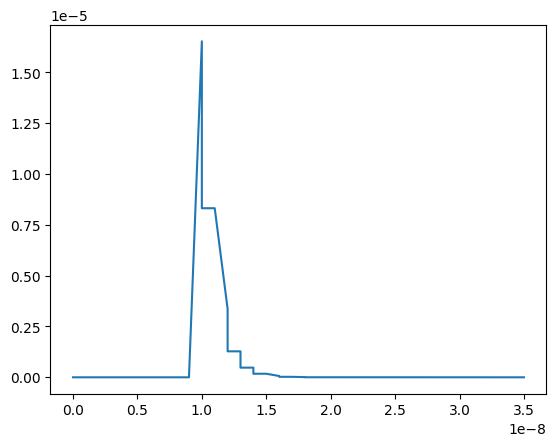

In [ ]:
# Plot de H_LeD convolucionado con componente H_LoS


plt.plot(time,Final_responsel[0:len(time)])
plt.show()


In [ ]:
h_vector_f = np.fft.fft(h_vector)
h_led_f = np.fft.fft(h_led)
h_tot_f = h_vector_f*h_led_f

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


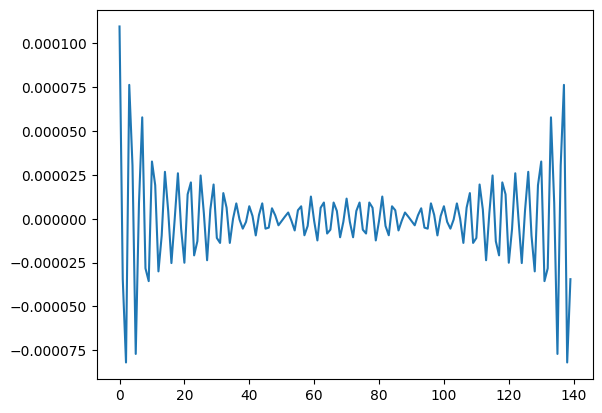

In [ ]:
# Plot de H_LeD convolucionado con componente H_LoS


plt.plot(h_tot_f)
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


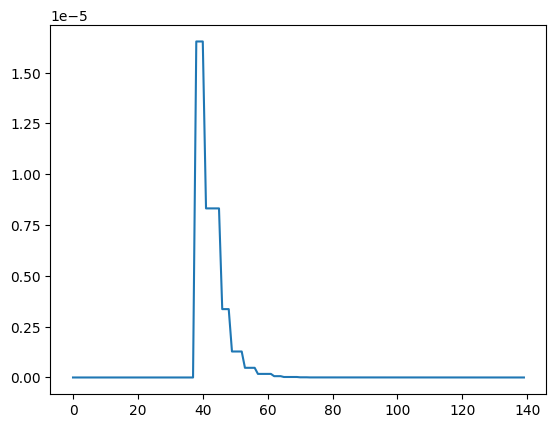

In [ ]:
yinv = ifft(h_tot_f)
plt.plot(yinv)
plt.show()

# CIR NLOS EN MUROS

In [ ]:
[i for i in range(Nx + 1)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [ ]:

#-------- Calculo del CIR para la componente nLoS de una pared total fija en eje y------#

a = 1  # indice para ir guardando componentes nLoS, delay, angulo de incidencia, angulo de inclinación y angulo de rotación
lx, ly, lz = 6, 3, 5  # Area del escenario Minero
Nx, Ny, Nz = lx * 3, ly * 3, round(lz * 3)  # numero de grid de cada superficie
dA = lz * ly / (Ny * Nz)  # area de cada grid
x = np.linspace(0, lx, Nx + 1)  # vector que cubre todo el grid en x
y = np.linspace(0, ly, Ny + 1)  # vector que cubre todo el grid en y
z = np.linspace(0, lz, Nz + 1)  # vector que cubre todo el grid en z
HnLos = np.zeros(len(time))  # vector donde se guarda la CIR del nLoS
tem = np.zeros(len(time))  # vector donde se guarda el delay del nLoS
incide = np.zeros(len(time))  # vector donde se el angulo de indicencia CIR del nLoS

for kk in range(Nx + 1):
    for ll in range(Nz + 1):
        WP1 = [x[kk], 0.2, z[ll]]  # ubicación de la pared fija en y se mueven en x y z
        r = random.randint(0, 90)  # angulo de rotacion del elemento reflectante aleatorio uniforme
        s = random.randint(0, 90)  # angulo de inclinación del elemento reflectante aleatorio uniforme
        incidenciaw_pru = incline(x[kk], 0.2, z[ll], x_j, y_j, z_j, alpha_j, beta_j)  # angulo de radiancia del LED al elemento reflectante
        incidenciawpru = np.degrees(incidenciaw_pru)  # conversion de radianes a grados
        # Función que calcula el CIR y el delay del nLoS
        m_HnLoSp, dnp = HnLos_calculation(x_i, y_i, z_i, x_j, y_j, z_j, x[kk], 0.2, z[ll], dA / 70, pw, alpha_i, alpha_j, r, beta_i, beta_j, s, Ap, incidenciawpru, incidenciaw_pru, eta, m, fov, gv, fv, W, H, X, Y, t, es, c)
        incide[a - 1] = incidenciawpru  # guarda angulo de incidencia
        HnLos[a - 1] = m_HnLoSp  # guarda CIR del nLoS
        tem[a - 1] = dnp  # guarda delay del nLoS
        a += 1

h_vector3 = np.zeros(len(time))  # vector donde se guarda el CIR del nLoS dependiendo del delay
tem = np.round(tem, 9)  # redondeo del vector de delays
indno = np.zeros(len(time))  # vector donde se guardara el indice del delay del nLoS = tiempo
indexno = 1
Final_responsen = np.zeros(len(np.convolve(h_led, h_vector3)))  # vector donde se guarda la conv entre CIR del LED y CIR nLoS

for i in range(len(time)):
    var = tem[i]  # guarda en una variable el delay
    var = round(var, 9)  # redonde el delay a 9 cifras significativas
    indexno = np.where(time == var)[0]  # encuentra el indice cuando el delay es igual al tiempo
    if indexno.size > 0:
        indno[i] = indexno[0]  # guarda ese indice en el vector de indices
        h_vector3[indexno[0]] += HnLos[i]  # coloca el CIR del nlos en el indice correspondiente




IndexError: index 140 is out of bounds for axis 0 with size 140

# Componente Scattering

In [ ]:
# -------- Calculo del CIR para la componente escattering -----
Hsca = np.zeros(len(time))
h_vector2 = np.zeros(len(time))
temsca = np.zeros(len(time))

# Función que calcula el CIR y el delay del scatter
m_Hscat1, ds1 = H_scater(x_i, y_i, z_i, x_j, y_j, z_j, Ap, m, f, g, gymma, kr, km, ks, p, N, irradiancia1, c, alpha_i, beta_i)
inds = np.zeros(len(time), dtype=int)

for i in range(len(m_Hscat1)):
    Hsca[i] = m_Hscat1[i]
    temsca[i] = ds1[i]

for i in range(len(time)):
    vars = temsca[i]
    vars = round(vars, 9)
    indexs = np.where(time == vars)[0]
    if indexs.size > 0:
        inds[i] = indexs[0]
        h_vector2[indexs[0]] += Hsca[i]




ValueError: setting an array element with a sequence.